In [1]:
library(ggplot2)
library(dplyr)

Warning message:
“package ‘ggplot2’ was built under R version 3.6.3”
Warning message:
“package ‘dplyr’ was built under R version 3.6.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [7]:
# list direcotries with 'C9ALSvsCTRL' in the name
root = '/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs'
dirs = list.dirs(root, recursive = F, full.names = T)
dirs = dirs[grep('C9ALSvsCTRL', dirs)]
dirs

[1] "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/AST-FB_C9ALSvsCTRL"          
 [2] "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/AST-PP_C9ALSvsCTRL"          
 [3] "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/Astrocytes_C9ALSvsCTRL"      
 [4] "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/Excitatory_C9ALSvsCTRL"      
 [5] "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/IN-PV_C9ALSvsCTRL"           
 [6] "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/IN-SST_C9ALSvsCTRL"          
 [7] "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/IN-VIP_C9ALSvsCTRL"          
 [8] "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/Inhibitory_C9ALSvsCTRL"      
 [9] "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/L2-3_C9ALSvsCTRL"            
[10] "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/L4_C9ALSvsCTRL"              
[11] "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/L5-6_C9ALSvsCTRL"            
[12] "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/L5-6-CC_C9ALSvsCTRL"         
[13] "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/Microglia_C9ALSvsCTRL"       
[14] "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/Oligodendrocytes_C9ALSvsCTRL"
[15] "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/OPC_C9ALSvsCTRL"

In [12]:
# for each directory in the dirs lets read in the APAlog_res_metadata_added.tsv file and save in the list
# 'df_list'
df_list = list()
for (dir in dirs){
    df = read.table(paste0(dir, '/APAlog_res_metadata_added.tsv'), header = T, sep = '\t')
    # lets exctact the celltype name from dir
    celltype = strsplit(dir, '/')[[1]][length(strsplit(dir, '/')[[1]])]
    # remove the C9ALSvsCTRL from celltype
    celltype = gsub('_C9ALSvsCTRL', '', celltype)
    # add the dir name to the df
    df_list[[celltype]] = df
}

In [13]:
names(df_list)

[1] "AST-FB"           "AST-PP"           "Astrocytes"       "Excitatory"      
 [5] "IN-PV"            "IN-SST"           "IN-VIP"           "Inhibitory"      
 [9] "L2-3"             "L4"               "L5-6"             "L5-6-CC"         
[13] "Microglia"        "Oligodendrocytes" "OPC"

In [55]:
# lets add sig_LFC_PA_Usage to 'Astrocyes' df,  0 if not sig: negativelogFDR < 1.3, else: the LFC_PA_Usage
df_list$Astrocytes = df_list$Astrocytes %>% mutate(sig_LFC_PA_Usage = ifelse(negative_logFDR < 1.3, LFC_PA_Usage, 0))


In [56]:
# for each celltype lets extract number of genes that have proximal PA choce (sig_LFC_PA_Usage < 0) and distal PA choice (sig_LFC_PA_Usage > 0)
# and save in the list 'gene_list'
gene_list = list()
for (celltype in names(df_list)){
    df = df_list[[celltype]]
    # extract genes with proximal PA choice, only unique genes
    proximal_genes = unique(df[df$sig_LFC_PA_Usage < -0.25, 'transcript'])

    # extract genes with distal PA choice, only unique genes
    distal_genes = unique(df[df$sig_LFC_PA_Usage > 0.25, 'transcript'])
    # save in the list
    gene_list[[celltype]] = list(proximal_genes = proximal_genes, distal_genes = distal_genes)
}

In [58]:
# lets first make a data frame with the number of genes with proximal and distal PA choice for each celltype
df = data.frame(celltype = character(), proximal_genes = numeric(), distal_genes = numeric())
for (celltype in names(gene_list)){
    proximal_genes = length(gene_list[[celltype]]$proximal_genes)
    distal_genes = length(gene_list[[celltype]]$distal_genes)
    df = rbind(df, data.frame(celltype = celltype, proximal_genes = proximal_genes, distal_genes = distal_genes))
}
df

celltype,proximal_genes,distal_genes
<fct>,<int>,<int>
AST-FB,311,537
AST-PP,4652,4426
Astrocytes,1682,1656
Excitatory,3274,4263
IN-PV,840,1563
IN-SST,1411,2735
IN-VIP,1261,2179
Inhibitory,3618,5643
L2-3,3173,3928


In [59]:
library(reshape2)
# melt df so we woould have two columns, with celltype and number of genes with proximal or distal PA choice
df = melt(df, id.vars = 'celltype')
df

celltype,variable,value
<fct>,<fct>,<int>
AST-FB,proximal_genes,311
AST-PP,proximal_genes,4652
Astrocytes,proximal_genes,1682
Excitatory,proximal_genes,3274
IN-PV,proximal_genes,840
IN-SST,proximal_genes,1411
IN-VIP,proximal_genes,1261
Inhibitory,proximal_genes,3618
L2-3,proximal_genes,3173


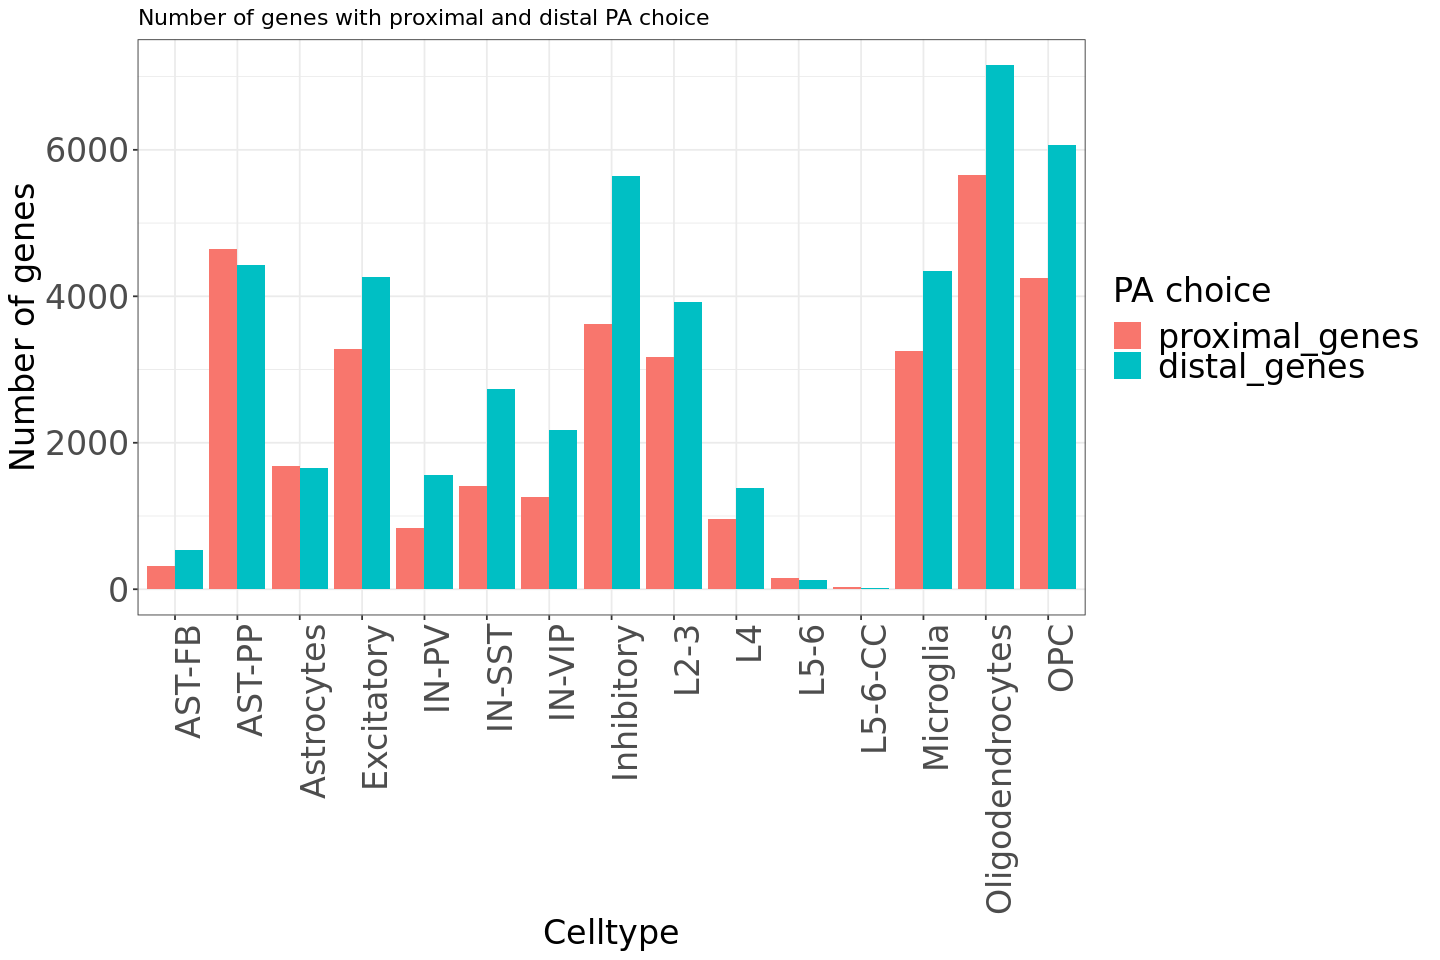

In [61]:
# lets make a paper ready, horizontal stacked bar plot for each celltype for proximal and distal PA choice, with number of genes
# standard size for paper
options(repr.plot.width=12, repr.plot.height=8)
ggplot(df, aes(x = celltype, y = value, fill = variable)) +
 geom_bar(stat = 'identity', position = 'dodge') + 
 # pretty theme and large text
    theme_bw() + theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 20), axis.text.y = element_text(size = 20), axis.title.x = element_text(size = 20), axis.title.y = element_text(size = 20), legend.text = element_text(size = 20), legend.title = element_text(size = 20)) +
    # add title
    labs(title = 'Number of genes with proximal and distal PA choice', x = 'Celltype', y = 'Number of genes') +
    # add legend
    guides(fill = guide_legend(title = 'PA choice'))

 # save plot in stadanrd size png, dpi 300
ggsave('Celltypes_APA_GENE.png', width = 12, height = 8, dpi = 300)
